In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os
folder_path = '/content/drive/MyDrive/Number_Plate/'
files = os.listdir(folder_path)
print(files)


['.DS_Store', 'dataset', 'anchors.py', 'ciou_loss.py', 'focal_loss.py', 'loss.py', 'wandb_config.py', 'dataset.py', '__pycache__', 'wandb', '.env', 'evaluation.py', 'utils.py', 'model.py', 'run.py', 'best_model_trial_0.pth', 'best_model_trial_1.pth', 'best_model_trial_2.pth', 'best_model_trial_3.pth', 'best_model_trial_4.pth', 'best_model_trial_5.pth', 'best_model_trial_6.pth', 'best_model_trial_7.pth', 'best_model_trial_8.pth', 'best_model_trial_9.pth', 'best_model_trial_11.pth', 'best_model_trial_12.pth', 'best_model_trial_13.pth', 'best_model_trial_14.pth', 'best_model_trial_15.pth']


In [4]:
cd /content/drive/MyDrive/Number_Plate/


/content/drive/MyDrive/Number_Plate


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 19.8 MB/s eta 0:00:00


In [ ]:
!pip install python-dotenv


In [ ]:
!python run.py

In [5]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

## ----------------------------------------------------------------------------
## The codes are referenced from the official research papers of CBAM author
## Multiple github repos are referenced for this architure
## I do not claim that this code is written by me
## The codes are referenced only for educational purpose
## All the referenced sources are outlined in the written report
## ----------------------------------------------------------------------------

class CBAM(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        # Channel attention
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1, bias=False)
        # Spatial attention
        self.spatial_conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Channel Attention
        avg_out = self.fc2(self.relu(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu(self.fc1(self.max_pool(x))))
        # Combining average and max pool paths
        scale = self.sigmoid(avg_out + max_out)
        # Channel attention scaling
        x = x * scale
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out = torch.max(x, dim=1, keepdim=True)[0]
        spatial_att = torch.cat([avg_out, max_out], dim=1)
        scale = self.sigmoid(self.spatial_conv(spatial_att))
        x = x * scale
        return x


class YOLOv4DenseNetCBAM(nn.Module):
    def __init__(self, num_classes=80):
        super(YOLOv4DenseNetCBAM, self).__init__()
        base_model = models.densenet121(pretrained=False)
        self.initial = nn.Sequential(
            base_model.features.conv0,
            base_model.features.norm0,
            base_model.features.relu0,
            base_model.features.pool0
        )
        self.block1 = base_model.features.denseblock1
        self.trans1 = base_model.features.transition1
        self.block2 = base_model.features.denseblock2
        self.trans2 = base_model.features.transition2
        self.block3 = base_model.features.denseblock3
        self.trans3 = base_model.features.transition3
        self.block4 = base_model.features.denseblock4
        self.norm5  = base_model.features.norm5
        del base_model

        self.cbam2 = CBAM(channels=512)
        self.cbam3 = CBAM(channels=1024)
        self.cbam4 = CBAM(channels=1024)

        self.num_classes = num_classes
        self.num_anchors = 3

        self.anchor_boxes = {
            'large':  [(10, 13), (16, 30), (33, 23)],
            'medium': [(30, 61), (62, 45), (59, 119)],
            'small':  [(116, 90), (156, 198), (373, 326)]
        }

        self.anchor_masks = {
            'small': [0, 1, 2],
            'medium': [3, 4, 5],
            'large': [6, 7, 8]
        }

        self.conv_route_small = nn.Conv2d(1024, 512, kernel_size=1)
        self.conv_pred_small  = nn.Conv2d(512, self.num_anchors * (5 + self.num_classes), kernel_size=1)
        self.conv_route_medium = nn.Conv2d(1536, 256, kernel_size=1)
        self.conv_pred_medium  = nn.Conv2d(256, self.num_anchors * (5 + self.num_classes), kernel_size=1)
        self.conv_route_large = nn.Conv2d(768, 128, kernel_size=1)
        self.conv_pred_large  = nn.Conv2d(128, self.num_anchors * (5 + self.num_classes), kernel_size=1)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        x = self.initial(x)
        x = self.block1(x)
        x = self.trans1(x)
        x = self.block2(x)
        out_large = x
        out_large = self.cbam2(out_large)
        x = self.trans2(x)
        x = self.block3(x)
        out_medium = x
        out_medium = self.cbam3(out_medium)
        x = self.trans3(x)
        x = self.block4(x)
        x = self.norm5(x)
        x = F.relu(x, inplace=True)
        out_small = x
        out_small = self.cbam4(out_small)
        route_small = self.conv_route_small(out_small)
        pred_small  = self.conv_pred_small(route_small)
        up_small   = self.upsample(route_small)
        fusion_mid = torch.cat([out_medium, up_small], dim=1)
        route_medium = self.conv_route_medium(fusion_mid)
        pred_medium  = self.conv_pred_medium(route_medium)
        up_medium  = self.upsample(route_medium)
        fusion_large = torch.cat([out_large, up_medium], dim=1)
        route_large = self.conv_route_large(fusion_large)
        pred_large  = self.conv_pred_large(route_large)
        return [pred_small, pred_medium, pred_large]


if __name__ == "__main__":
    model = YOLOv4DenseNetCBAM(num_classes=80)  ## Testing purpose
    model.eval()                                ## Output dimension shape
    dummy_input = torch.randn(1, 3, 416, 416)
    outputs = model(dummy_input)
    for name, output in zip(["Small (13x13)", "Medium (26x26)", "Large (52x52)"], outputs):
        print(f"{name} output shape: {output.shape}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Small (13x13) output shape: torch.Size([1, 255, 13, 13])
Medium (26x26) output shape: torch.Size([1, 255, 26, 26])
Large (52x52) output shape: torch.Size([1, 255, 52, 52])


In [21]:
import torch
import cv2
import numpy as np

from torchvision import transforms
from google.colab.patches import cv2_imshow

# Config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = 416
NUM_CLASSES = 1
CONF_THRESH = 0.2
IOU_THRESH = 0.5

# Load model
model = YOLOv4DenseNetCBAM(num_classes=NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load("/content/best_model_trial_11.pth", map_location=DEVICE))
model.eval()

# Anchors, masks, image size
model.anchors = {
    'large':  torch.tensor([(10, 13), (16, 30), (33, 23)], dtype=torch.float32).to(DEVICE),
    'medium': torch.tensor([(30, 61), (62, 45), (59, 119)], dtype=torch.float32).to(DEVICE),
    'small':  torch.tensor([(116, 90), (156, 198), (373, 326)], dtype=torch.float32).to(DEVICE)
}
model.anchor_masks = {
    'small': [0, 1, 2],
    'medium': [3, 4, 5],
    'large': [6, 7, 8]
}
model.image_size = IMAGE_SIZE

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

def preprocess_image(image_path):
    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_tensor = transform(img_rgb).unsqueeze(0).to(DEVICE)
    return img_tensor, img_bgr

def xywh_to_xyxy(x, y, w, h, img_w, img_h):
    x1 = int((x - w / 2) * img_w)
    y1 = int((y - h / 2) * img_h)
    x2 = int((x + w / 2) * img_w)
    y2 = int((y + h / 2) * img_h)
    return x1, y1, x2, y2

def non_max_suppression(boxes, confs, iou_threshold):
    idxs = torch.argsort(confs, descending=True)
    keep = []
    while idxs.numel() > 0:
        i = idxs[0].item()
        keep.append(i)
        if idxs.numel() == 1:
            break
        ious = compute_iou(boxes[i], boxes[idxs[1:]])
        idxs = idxs[1:][ious <= iou_threshold]
    return keep

def compute_iou(box1, boxes):
    x1 = torch.max(box1[0], boxes[:, 0])
    y1 = torch.max(box1[1], boxes[:, 1])
    x2 = torch.min(box1[2], boxes[:, 2])
    y2 = torch.min(box1[3], boxes[:, 3])
    inter_area = torch.clamp(x2 - x1, 0) * torch.clamp(y2 - y1, 0)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    union = box1_area + boxes_area - inter_area
    return inter_area / (union + 1e-6)

def decode_predictions(predictions, conf_thresh):
    boxes_all = []
    for i, scale in enumerate(['small', 'medium', 'large']):
        pred = predictions[i]  # shape: (1, 3*(5+C), H, W)
        B, _, H, W = pred.shape
        pred = pred.view(B, 3, 5 + NUM_CLASSES, H, W).permute(0, 1, 3, 4, 2).squeeze(0)
        anchors = model.anchors[scale]

        for a in range(3):
            for j in range(H):
                for i in range(W):
                    tx, ty, tw, th, conf = pred[a, j, i, :5]
                    conf = torch.sigmoid(conf)
                    if conf < conf_thresh:
                        continue
                    cx = (i + torch.sigmoid(tx).item()) / W
                    cy = (j + torch.sigmoid(ty).item()) / H
                    bw = anchors[a][0].item() * torch.exp(tw).item() / IMAGE_SIZE
                    bh = anchors[a][1].item() * torch.exp(th).item() / IMAGE_SIZE
                    boxes_all.append([cx, cy, bw, bh, conf.item()])
    return boxes_all

def draw_boxes(boxes, original_img):
    H, W, _ = original_img.shape
    boxes_xyxy = []
    confs = []
    for box in boxes:
        x_c, y_c, w, h, conf = box
        x1, y1, x2, y2 = xywh_to_xyxy(x_c, y_c, w, h, W, H)
        boxes_xyxy.append([x1, y1, x2, y2])
        confs.append(conf)

    boxes_tensor = torch.tensor(boxes_xyxy, dtype=torch.float32)
    confs_tensor = torch.tensor(confs)
    keep = non_max_suppression(boxes_tensor, confs_tensor, IOU_THRESH)

    for i in keep:
        x1, y1, x2, y2 = boxes_xyxy[i]
        cv2.rectangle(original_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(original_img, f"{confs[i]:.2f}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    return original_img



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [22]:
import pytesseract

def draw_boxes_with_ocr(boxes, original_img):
    H, W, _ = original_img.shape
    boxes_xyxy = []
    confs = []
    texts = []

    for box in boxes:
        x_c, y_c, w, h, conf = box
        x1, y1, x2, y2 = xywh_to_xyxy(x_c, y_c, w, h, W, H)
        boxes_xyxy.append([x1, y1, x2, y2])
        confs.append(conf)

    boxes_tensor = torch.tensor(boxes_xyxy, dtype=torch.float32)
    confs_tensor = torch.tensor(confs)
    keep = non_max_suppression(boxes_tensor, confs_tensor, IOU_THRESH)

    for i in keep:
        x1, y1, x2, y2 = boxes_xyxy[i]
        roi = original_img[y1:y2, x1:x2]

        # Reading for OCR preprocessing
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        blur = cv2.bilateralFilter(gray, 11, 17, 17)
        thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

        # pytesract OCR
        text = pytesseract.image_to_string(thresh, config="--psm 8")  # psm 8: single word
        text = text.strip()
        texts.append(text)

        # BBOX
        cv2.rectangle(original_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(original_img, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

        print(f"Detected Text: {text}")

    return original_img


Detected Text: | | SNGG XMZ | |


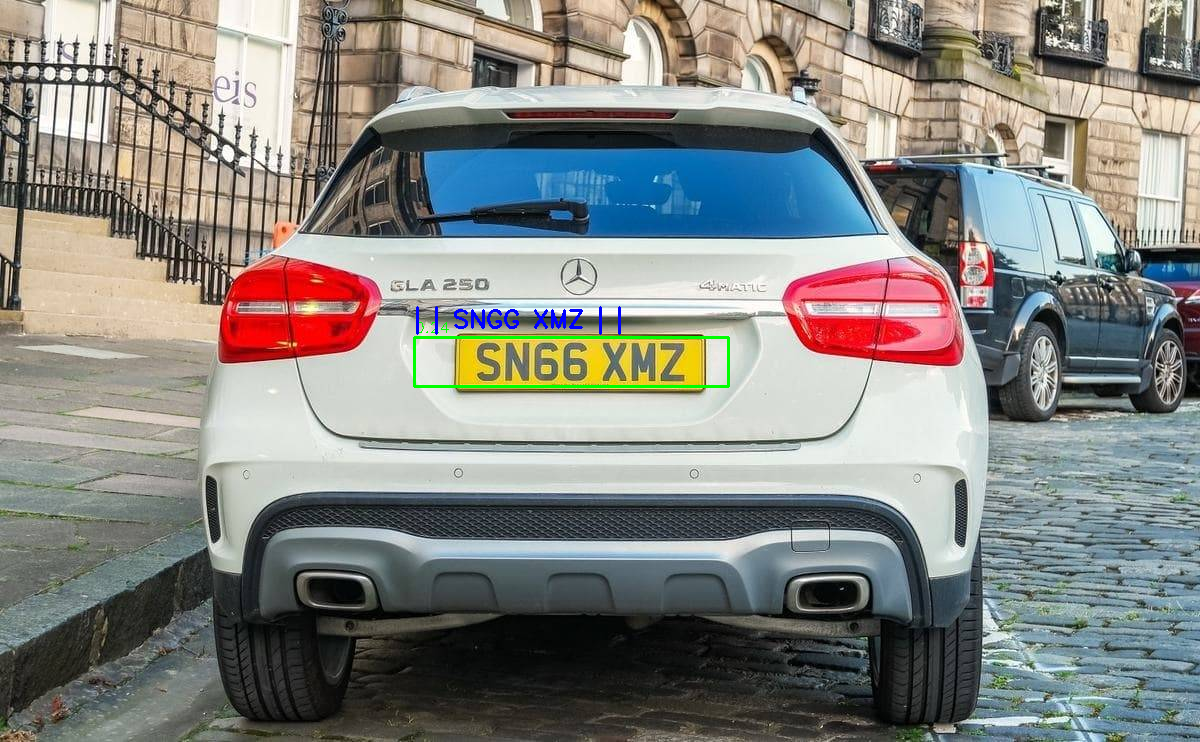

In [23]:
# Inference on image
image_path = "/content/car.jpg"




with torch.no_grad():
    predictions = model(img_tensor)
    boxes = decode_predictions(predictions, CONF_THRESH)
    result_img = draw_boxes_with_ocr(boxes, orig_img)
    cv2_imshow(result_img)


Detected Text: MeLC250U0 ~~


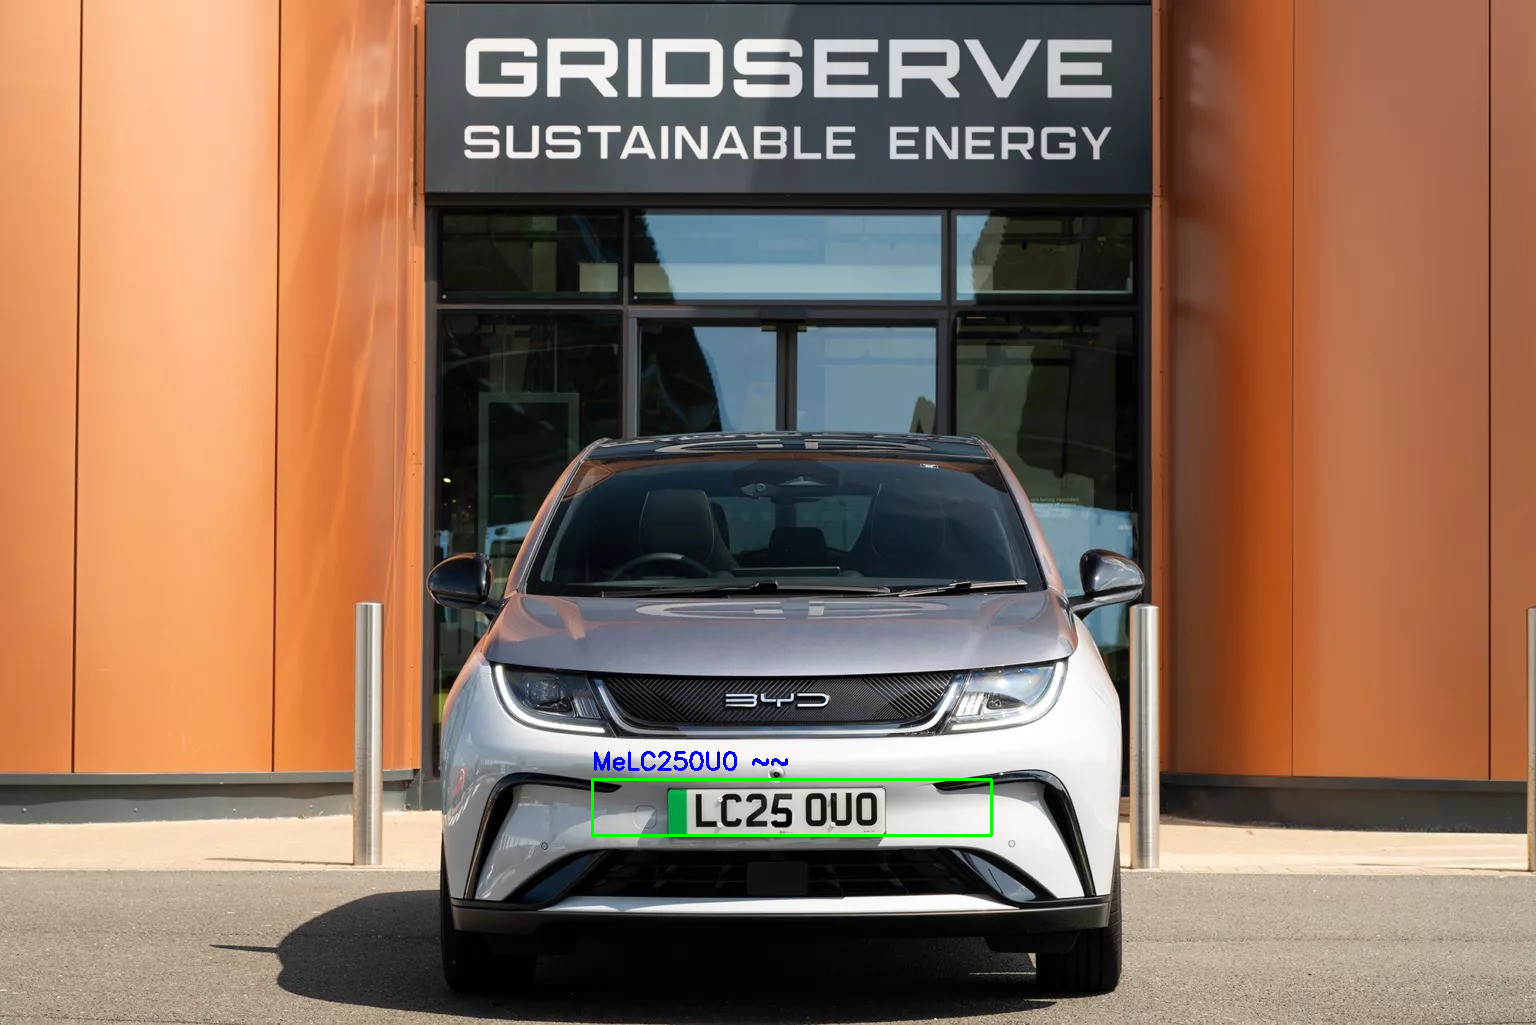

In [28]:
# Inference on new image
image_path = "/content/car1.jpg"


img_tensor, orig_img = preprocess_image(image_path)

with torch.no_grad():
    predictions = model(img_tensor)
    boxes = decode_predictions(predictions, CONF_THRESH)
    result_img = draw_boxes_with_ocr(boxes, orig_img)
    cv2_imshow(result_img)
